In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf
import shap
from matplotlib import colors
import random


2023-03-01 16:24:31.029238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 16:24:31.121873: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 16:24:31.462779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 16:24:31.462813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [84]:
with open('../data/prepared_data/SW_only_OTT_train_dict.pkl', 'rb') as f:
	sw_train_dict = pickle.load(f)

with open('../data/prepared_data/SW_only_OTT_test_dict.pkl', 'rb') as d:
	sw_test_dict = pickle.load(d)

with open('../data/prepared_data/combined_OTT_train_dict.pkl', 'rb') as c:
	combined_train_dict = pickle.load(c)

with open('../data/prepared_data/OTT_test_dict.pkl', 'rb') as b:
	combined_test_dict = pickle.load(b)

sw_model = load_model('models/OTT/CNN_SW_only_split_50.h5')
combined_model = load_model('models/OTT/CNN_version_5_split_50.h5')

results = pd.read_feather('outputs/OTT/SW_only_storm_4.feather')

In [86]:
print(sw_train_dict['X'].shape)
print(sw_test_dict['storm_0']['Y'].shape)
print(combined_train_dict['X'].shape)
print(combined_test_dict['storm_0']['Y'].shape)

(834961, 30, 10)
(5792, 30, 10)
(834953, 30, 16)
(5792, 30, 16)


In [87]:
# reducing the amount of the training dataset used to find the shap values
combined_xtrain = combined_train_dict['X']
combined_xtrain = combined_xtrain.reshape((combined_xtrain.shape[0], combined_xtrain.shape[1], combined_xtrain.shape[2], 1))
combined_background = combined_xtrain[np.random.choice(combined_xtrain.shape[0], 1000, replace=False)]

# attempting to use shap
combined_explainer = shap.DeepExplainer(combined_model, combined_background)

sw_xtrain = sw_train_dict['X']
sw_xtrain = sw_xtrain.reshape((sw_xtrain.shape[0], sw_xtrain.shape[1], sw_xtrain.shape[2], 1))
sw_background = sw_xtrain[np.random.choice(sw_xtrain.shape[0], 1000, replace=False)]

# attempting to use shap
sw_explainer = shap.DeepExplainer(sw_model, sw_background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [88]:
combined, solar, combined_unscaled, solar_unscaled = [], [], [], []
for comb, sw in zip(combined_test_dict.keys(), sw_test_dict.keys()):
	combined.append(combined_test_dict[comb]['Y'])
	solar.append(sw_test_dict[sw]['Y'])
	combined_unscaled.append(combined_test_dict[comb]['unscaled_array'])
	solar_unscaled.append(sw_test_dict[sw]['unscaled_array'])

combined_xtest = np.concatenate(combined, axis=0)
solarwind_xtest = np.concatenate(solar, axis=0)
combined_unscaled = np.concatenate(combined_unscaled, axis=0)
solarwind_unscaled = np.concatenate(solar_unscaled, axis=0)

combined_xtest = combined_xtest.reshape((combined_xtest.shape[0], combined_xtest.shape[1], combined_xtest.shape[2], 1))
solarwind_xtest = solarwind_xtest.reshape((solarwind_xtest.shape[0], solarwind_xtest.shape[1], solarwind_xtest.shape[2], 1))


KeyError: 'unscaled_array'

In [7]:
shap_values = explainer.shap_values(Xtest, check_additivity=False)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [55]:
sw_features = ["sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   		"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T"]
combined_features = ["N", "E", "sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   					"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T",
	   					 "AE_INDEX", "SZA", "dBHt", "B"]

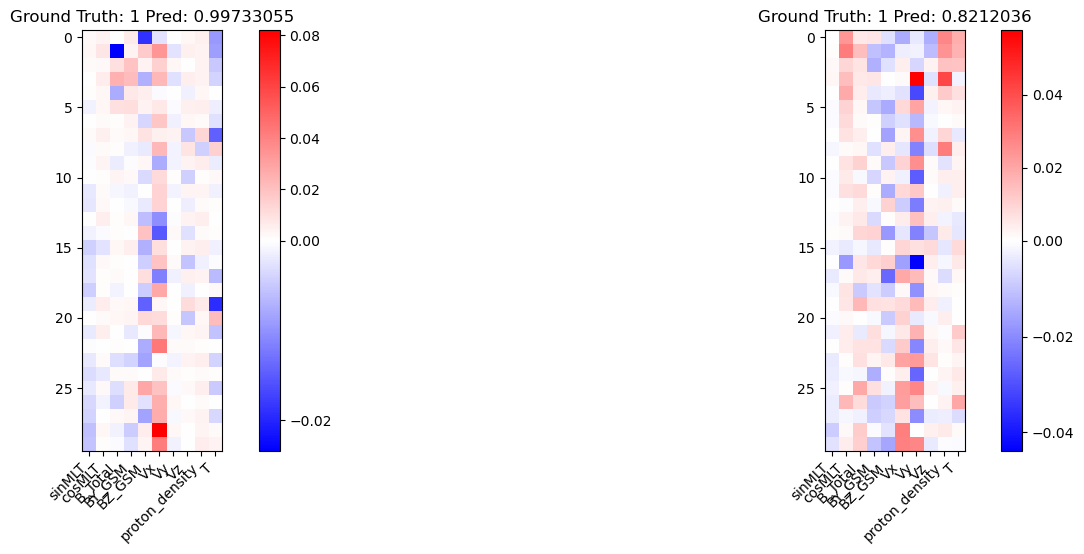

In [17]:
len_xtest = len(Xtest)
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(221)
step = random.randint(0,len_xtest)
plt.title('Ground Truth: '+str(test_dict['storm_4']['real_df']['crossing'][step])+' Pred: '+str(results['predicted_split_50'][step]))
divnorm=colors.TwoSlopeNorm(vcenter=0)
plt.imshow(shap_values[1][step], cmap='bwr', norm=divnorm)
plt.colorbar()
x = [i for i in range(shap_values[1].shape[2])]
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')

ax = plt.subplot(222)
step = random.randint(0,len_xtest)
plt.title('Ground Truth: '+str(test_dict['storm_4']['real_df']['crossing'][step])+' Pred: '+str(results['predicted_split_50'][step]))
divnorm=colors.TwoSlopeNorm(vcenter=0)
plt.imshow(shap_values[1][step], cmap='bwr', norm=divnorm)
plt.colorbar()
x = [i for i in range(shap_values[1].shape[2])]
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [75]:
def creating_plotting_df(shap_array, Xtest, param, param_loc):

	plotting_df = pd.DataFrame()

	shap_array = shap_array[:,:,:,0]

	nums = [30-i for i in range(30)]
	i = 0
	for arr, test in zip(shap_array, Xtest):
		df = pd.DataFrame({'shap_values':arr[:, param_loc],
							param: test[:, param_loc],
							'time_hist':nums})
		if i == 2900:
			print(df)
			print(test)
		plotting_df = pd.concat([plotting_df, df], axis=0, ignore_index=True).reset_index(drop=True)
		i+=1
	print(plotting_df.shape)
	plotting_df.dropna(inplace=True)
	print(plotting_df.shape)
	return plotting_df

In [76]:
plotting_df = creating_plotting_df(shap_values[1], unscaled_Xtest, 'Vx', features.index('Vx'))

    shap_values          Vx  time_hist
0      0.004279  676.640015         30
1      0.011163  676.640015         29
2      0.020114  676.640015         28
3      0.017565  676.640015         27
4      0.010389  676.640015         26
5      0.000726  676.640015         25
6      0.013438  680.130005         24
7      0.015260  680.130005         23
8      0.015373  680.130005         22
9      0.005164  680.130005         21
10    -0.000746  680.130005         20
11     0.015403  680.130005         19
12     0.004933  680.130005         18
13     0.007056  680.130005         17
14     0.003472  680.130005         16
15     0.009474  680.130005         15
16     0.004667  680.130005         14
17     0.016157  680.130005         13
18    -0.001656  664.650024         12
19    -0.001469  664.650024         11
20     0.009998  664.650024         10
21     0.010300  664.650024          9
22     0.007260  664.650024          8
23     0.016454  664.650024          7
24     0.011679  664.6500

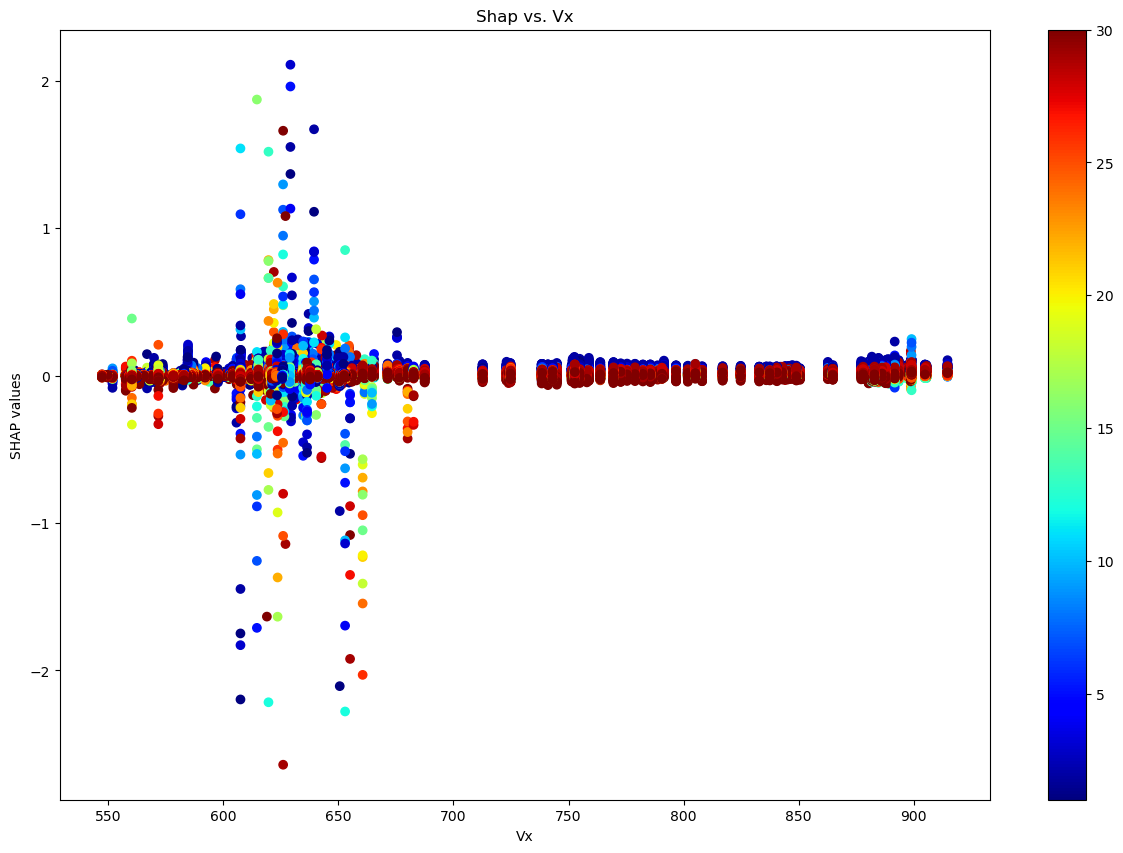

In [81]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

plt.title('Shap vs. Vx')
plt.scatter(x=plotting_df['Vx'], y=plotting_df['shap_values'], c=plotting_df['time_hist'], cmap='jet')
plt.colorbar()
plt.xlabel('Vx')
plt.ylabel('SHAP values')
plt.show()